In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
from pandas import Series

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import f1_score, accuracy_score, roc_curve, roc_auc_score, plot_roc_curve
from sklearn.metrics import classification_report, precision_score, recall_score, plot_precision_recall_curve
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/sf-dst-scoring/sample_submission.csv
/kaggle/input/sf-dst-scoring/train.csv
/kaggle/input/sf-dst-scoring/test.csv


In [2]:
# Функция ниже визуализирует распределние числового признака
# разделяя на вернувших и не вернувших кредит

def distrib_function(colum, bins, rang):
    zero = df[df.sample_kaggle == 1][df.default == 0]
    one = df[df.sample_kaggle == 1][df.default == 1]

    print('Вернувшии клиенты  ' + colum)
    plt.subplot(2, 1, 1)

    plt.hist(zero[colum], bins, range=rang, edgecolor='black')

    plt.subplot(2, 1, 2)

    plt.hist(one[colum], bins, range=rang, edgecolor='red')

    plt.show()
    print('Невернувшии клиенты  ' + colum)

    print('----------------------')
    print('Вернувшии')
    display(zero[colum].describe())

    print('Невернувшии')
    display(one[colum].describe())


# эта функция принимает категориальный признак и группирует по нему
# 3 числовых признака разделяя их на вернувших и не вернувших
# Функция возврощает соотношение по каждой категории категориального
# признака вернувших и не вернувших долг и 3 графика

def default_ratio(column):

    display(df[df.sample_kaggle == 1].groupby(
        column).default.value_counts(normalize=True))
    cols = ['age', 'score_bki', 'income']
    ylimits = [[20, 80], [-5, 1], [0, 150000]]

    fig, axes = plt.subplots(1, 3, figsize=(20, 7))
    i = 0
    for col, lim in zip(cols, ylimits):

        plt.ylim(lim)
        display(sns.boxplot(ax=axes[i], x=column, y=col,
                            data=df[df.sample_kaggle == 1], hue='default'))
        i += 1


def delete_outliers(value):

    if (value >= low_bound) & (value <= top_bound):
        return value
    elif value > top_bound:
        return top_bound

    else:
        return low_bound


# Эта функция для расчета результатов модели

def result_calculations(x_test, y_test, model):

    probs = model.predict_proba(x_test)
    probs = probs[:, 1]

    roc_auc = roc_auc_score(y_test, probs)
    display(roc_auc)

    y_pred = model.predict(x_test)
    print('confusion_matrix')
    display(confusion_matrix(y_test, y_pred))

    print('Precision Score')
    display(precision_score(y_test, model.predict(x_test)))

    print('f_value')
    display(f1_score(y_test, model.predict(x_test)))

    print('precision negative')
    display(precision_score(y_test, model.predict(x_test), pos_label=0))

    print('precision positive')
    display(precision_score(y_test, model.predict(x_test), pos_label=1))

    print('recall negative')
    display(recall_score(y_test, model.predict(x_test), pos_label=0))

    print('recall postive')
    display(recall_score(y_test, model.predict(x_test), pos_label=1))

    calc_and_plot_roc(y_test, probs)


def calc_and_plot_roc(y_true, y_pred_proba):
    # Посчитать значения ROC кривой и значение площади под кривой AUC
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    roc_auc = roc_auc_score(y_true, y_pred_proba)

    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.title('Receiver Operating Characteristic', fontsize=15)
    plt.xlabel('False positive rate (FPR)', fontsize=15)
    plt.ylabel('True positive rate (TPR)', fontsize=15)
    plt.legend(fontsize=15)

# Data

In [3]:
# Создаем два DataFrame train для тренеровки модели и
# test окончательного тестирования

train = pd.read_csv('/kaggle/input/sf-dst-scoring/train.csv')
test= pd.read_csv('/kaggle/input/sf-dst-scoring/test.csv')

In [4]:
# Создаем в test отсутствующую колонку default и заполняем
# любым значением например 2

test['default'] = 2

# пометить где train и где test ряды

train['sample_kaggle'] = 1
test['sample_kaggle'] = 0


# Обьеденяем их в один DataFrame df

df = test.append(train, sort=False).reset_index(drop=True)

In [5]:
df

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,sample_kaggle
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N,2,0
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N,2,0
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y,2,0
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N,2,0
4,28862,04FEB2014,GRD,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110143,54887,04MAR2014,GRD,F,45,N,N,0,0,-1.792064,3,50,1,2,17000,4,4,N,0,1
110144,76821,24MAR2014,SCH,M,41,Y,Y,0,0,-2.058029,1,50,2,2,70000,1,4,N,0,1
110145,103695,22APR2014,SCH,M,31,N,N,0,0,-1.512635,4,80,2,3,45000,2,2,N,0,1
110146,861,04JAN2014,SCH,F,29,N,N,0,1,-1.479334,3,50,1,3,13000,2,3,N,1,1


In [6]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

In [7]:
# В заполнение даные особенно не нуждаются, кроме не большого количества
# пропусков в признаке education. В списке выше видно некоторое количество
# признаков типа object над ними придется поработать чтоб их в модель внести потом

# Обработка и Заполнение Пропусков

In [8]:
# Заполняем не большое количество пропусков в колонки 'education'
# самым частым значением

school = df.education.value_counts().index[0]


def fill_education(edu):
    if pd.notna(edu):
        return edu

    else:
        return school


df['education'] = df.education.apply(fill_education)

df.info()
# train[pd.isna(train.education)].default.value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         110148 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

In [9]:
# one hot encoding для education колонки

df['ed'] = df['education']

df = pd.get_dummies(df, columns=[ 'ed',], dummy_na=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 26 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         110148 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

In [10]:
# get_dummies для бинарных колонок

bin_cols = ['sex', 'car', 'car_type', 'foreign_passport']

for column in bin_cols:
    df = pd.get_dummies(df, columns=[ column,], dummy_na=True)
    
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 34 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   client_id             110148 non-null  int64  
 1   app_date              110148 non-null  object 
 2   education             110148 non-null  object 
 3   age                   110148 non-null  int64  
 4   decline_app_cnt       110148 non-null  int64  
 5   good_work             110148 non-null  int64  
 6   score_bki             110148 non-null  float64
 7   bki_request_cnt       110148 non-null  int64  
 8   region_rating         110148 non-null  int64  
 9   home_address          110148 non-null  int64  
 10  work_address          110148 non-null  int64  
 11  income                110148 non-null  int64  
 12  sna                   110148 non-null  int64  
 13  first_time            110148 non-null  int64  
 14  default               110148 non-null  int64  
 15  

In [11]:
# выброшу не нужные колонки, потому что там пропусков не было

df = df.drop(['ed_nan', 'sex_nan', 'car_nan', 'car_type_nan', 'foreign_passport_nan',
              'car_N', 'car_type_N', 'sex_F', 'foreign_passport_N'], axis=1)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 25 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   client_id           110148 non-null  int64  
 1   app_date            110148 non-null  object 
 2   education           110148 non-null  object 
 3   age                 110148 non-null  int64  
 4   decline_app_cnt     110148 non-null  int64  
 5   good_work           110148 non-null  int64  
 6   score_bki           110148 non-null  float64
 7   bki_request_cnt     110148 non-null  int64  
 8   region_rating       110148 non-null  int64  
 9   home_address        110148 non-null  int64  
 10  work_address        110148 non-null  int64  
 11  income              110148 non-null  int64  
 12  sna                 110148 non-null  int64  
 13  first_time          110148 non-null  int64  
 14  default             110148 non-null  int64  
 15  sample_kaggle       110148 non-nul

In [12]:
# создаем колонку месяц (когда подали)

from time import strptime

def month_column(date):
    month = date[2:5]
    num = strptime(month,'%b').tm_mon
    
    return num

df['month'] = df.app_date.apply(month_column)
    
   

In [13]:
# создаем колонку какого числа подовали

def day_month(date):
    day = date[:2]
    num = int(day)
    
    return num

df['day_of_month'] = df.app_date.apply(day_month)
    

In [14]:
# Очищаем признак 'decline_app_cnt' от выбрасов

def dec_outliers(dec):
    if dec <= 4:
        return dec
    
    else:
        return 4
    
df['decline_app_cnt'] = df.decline_app_cnt.apply(dec_outliers)

In [15]:
# Очищаем признак 'income' от выбрасов

perc25 = df.income.quantile(0.25)
perc50 = df.income.quantile(0.5)
perc75 = df.income.quantile(0.75)

low_bound = perc25 - 1.5 * (perc75 - perc25)
top_bound = perc75 + 1.5 * (perc75 - perc25)




df['income'] = df.income.apply(delete_outliers)

In [16]:
# Очищаем признак 'bki_request_cnt' от выбрасов

perc25 = df.bki_request_cnt.quantile(0.25)
perc50 = df.bki_request_cnt.quantile(0.5)
perc75 = df.bki_request_cnt.quantile(0.75)

low_bound = round(perc25 - 1.5 * (perc75 - perc25))
top_bound = round(perc75 + 1.5 * (perc75 - perc25))




df['bki_request_cnt'] = df.bki_request_cnt.apply(delete_outliers)

df.bki_request_cnt.value_counts()

0    28908
1    27295
2    20481
3    13670
4     8406
5     4960
8     2636
6     2500
7     1292
Name: bki_request_cnt, dtype: int64

# Анализ и Распределение Признаков

<AxesSubplot:>

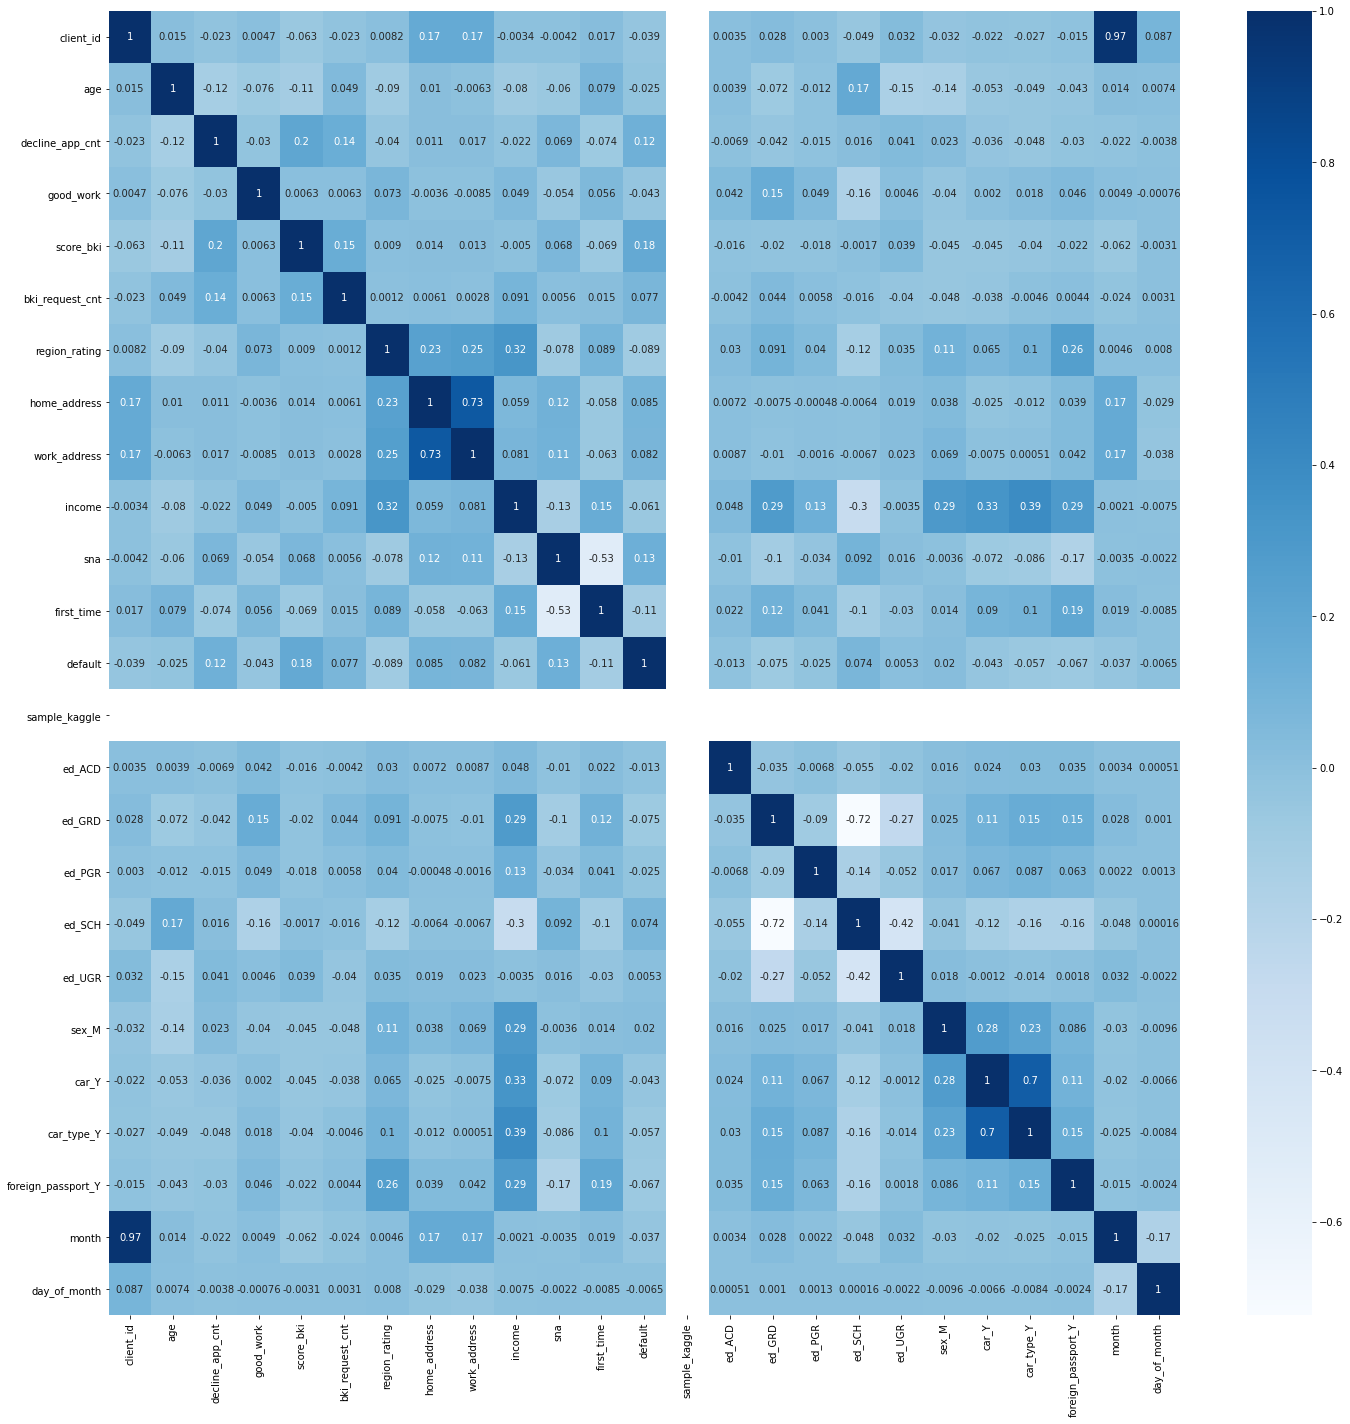

In [17]:

plt.figure(figsize=(24,24))
sns.heatmap(df[df.sample_kaggle == 1].corr(), annot=True, cmap='Blues')

<AxesSubplot:>

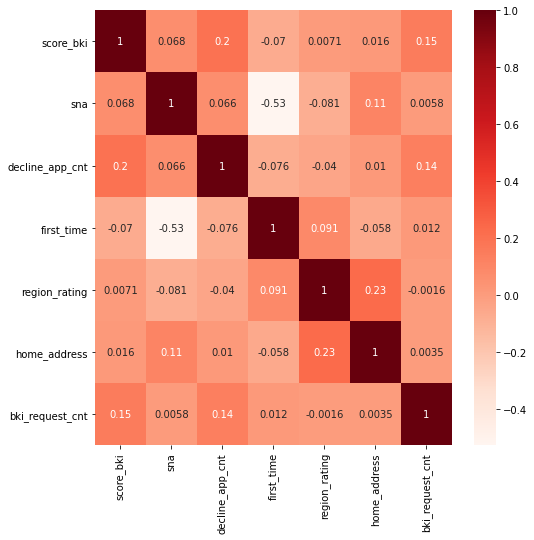

In [18]:
# Из корреляционой карты выше видно, что с целевой переменной хоть как-то коррелируют
# признаки: 'score_bki', 'sna', 'decline_app_cnt', 'first_time', 'region_rating', 'home_address', 'bki_request_cnt'

# Посмотрим как они между друг другом коррелируют

cor_tble = df[['score_bki', 'sna', 'decline_app_cnt', 'first_time', 'region_rating',
               'home_address', 'bki_request_cnt']].corr()

plt.figure(figsize=(8, 8))
sns.heatmap(cor_tble, annot=True, cmap='Reds')

In [19]:
# Самая большая корреляция между 'sna' и 'first_time'
# С признаком 'score_bki' (признак который больше всего коррелирует с 'default') 
# коррелируют больше всего признаки 'decline_app_cnt', 'bki_request_cnt'

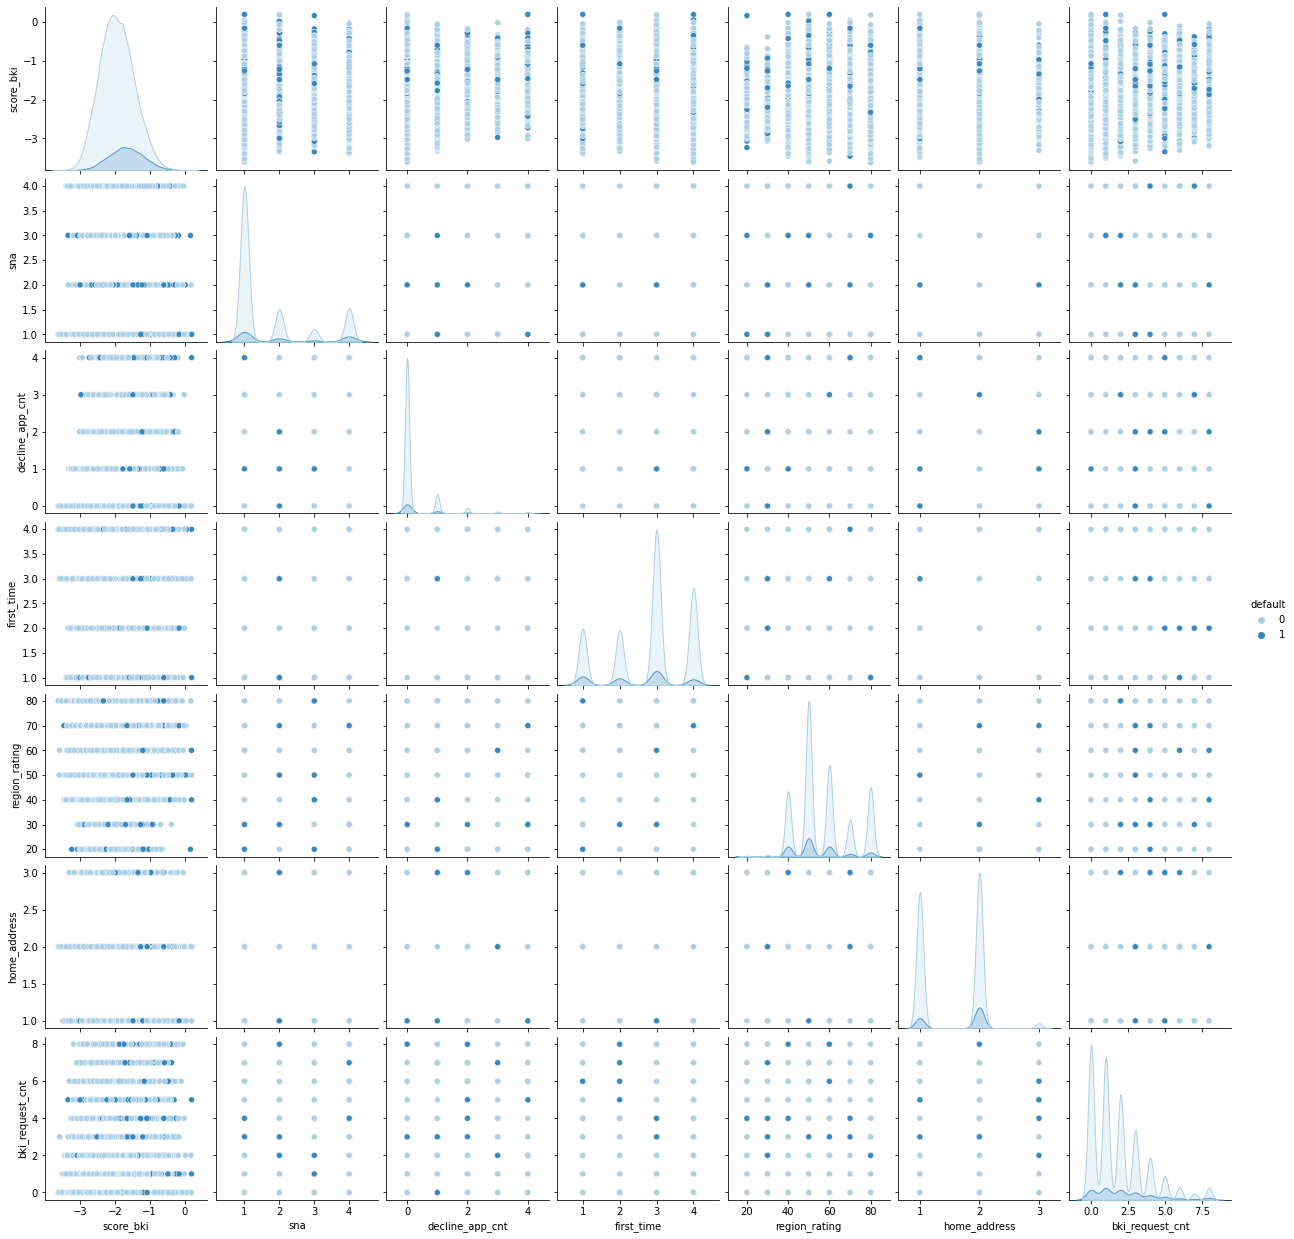

In [20]:
# графическое соотношения между признаками
# темные пятна те кто не вернули кредит и светлые это те кто вернули кредит


sns.pairplot(df[df.sample_kaggle == 1][['score_bki', 'sna', 'decline_app_cnt', 'first_time',
                                        'region_rating', 'home_address', 'bki_request_cnt',
                                        'default']], hue='default', palette='Blues')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Вернувшии клиенты  score_bki


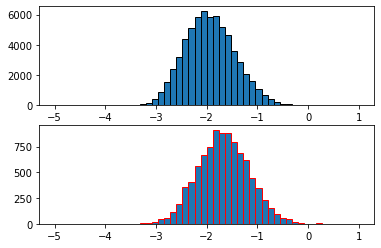

Невернувшии клиенты  score_bki
----------------------
Вернувшии


count    64427.000000
mean        -1.938048
std          0.489903
min         -3.624586
25%         -2.284749
50%         -1.956982
75%         -1.609687
max          0.199773
Name: score_bki, dtype: float64

Невернувшии


count    9372.000000
mean       -1.675637
std         0.494691
min        -3.456086
25%        -2.015871
50%        -1.683857
75%        -1.337922
max         0.199773
Name: score_bki, dtype: float64

In [21]:
distrib_function('score_bki', 50, (-5, 1))

In [22]:
#'score_bki' распределение почти нормальное, только не вернувшии больше сдвинуты к нулю

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
 

<AxesSubplot:xlabel='score_bki', ylabel='Density'>

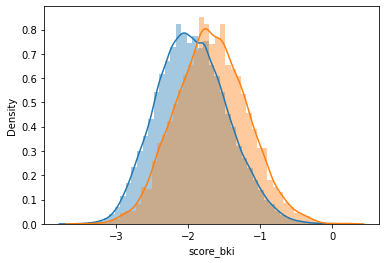

In [23]:
zero = df[df.sample_kaggle == 1][df.default == 0]
one = df[df.sample_kaggle == 1][df.default == 1]



sns.distplot(zero.score_bki)
sns.distplot(one.score_bki)

In [24]:



#sns.jointplot(x = 'score_bki', y='default', data = df[df.sample_kaggle == 1], kind='scatter')

sna  default
1    0          0.901799
     1          0.098201
2    0          0.850179
     1          0.149821
3    0          0.842348
     1          0.157652
4    0          0.788493
     1          0.211507
Name: default, dtype: float64

<AxesSubplot:xlabel='sna', ylabel='age'>

<AxesSubplot:xlabel='sna', ylabel='score_bki'>

<AxesSubplot:xlabel='sna', ylabel='income'>

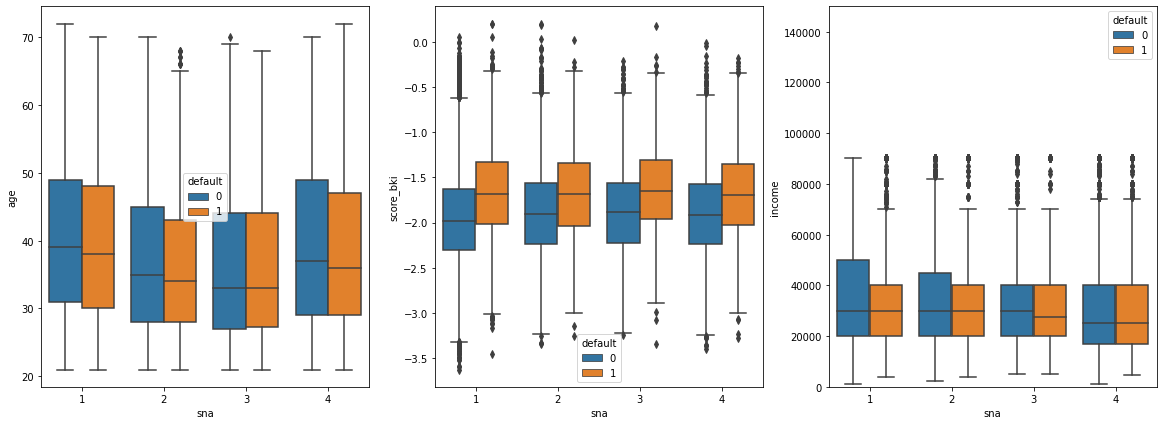

In [25]:
# Расмотрим категориальный признак 'sna', как соотношение вернувших
# и не вернувших изменяется по категориям этого признака


default_ratio('sna')    

In [26]:
# Чем больше 'sna' тем выше вероятность невозврата кредита.
# В каждой категории 'sna' возраст примерно одинаковый у вернувших и невернувших.
# По всем категориям этого признака score_bki ниже у вернувших и выше у невернувших, и 
# эти значения примерно одинаковые по всем категориям.
# Уровень 'income' почти один и тот-же по всем категориям.
 


decline_app_cnt  default
0                0          0.890466
                 1          0.109534
1                0          0.812195
                 1          0.187805
2                0          0.756483
                 1          0.243517
3                0          0.726467
                 1          0.273533
4                0          0.703794
                 1          0.296206
Name: default, dtype: float64

<AxesSubplot:xlabel='decline_app_cnt', ylabel='age'>

<AxesSubplot:xlabel='decline_app_cnt', ylabel='score_bki'>

<AxesSubplot:xlabel='decline_app_cnt', ylabel='income'>

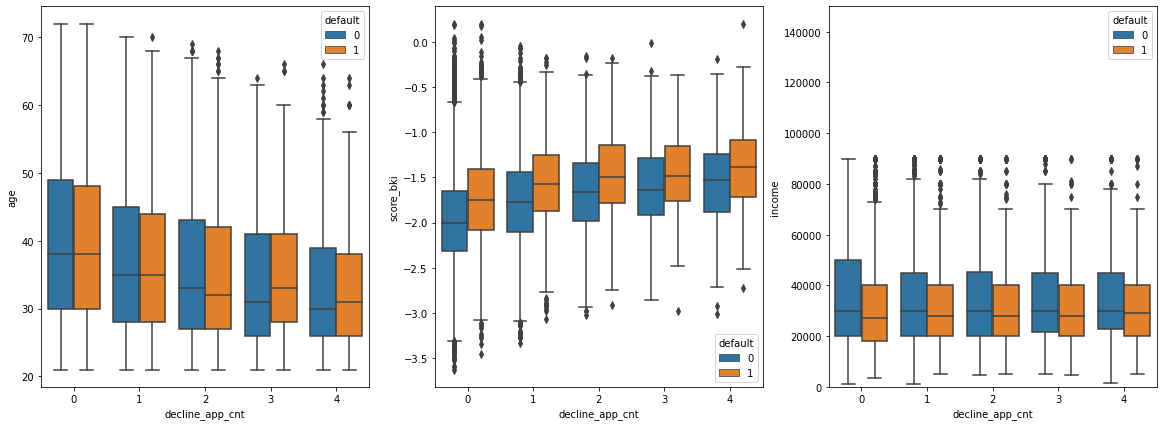

In [27]:
# Расмотрим категориальный признак 'decline_app_cnt', как соотношение вернувших
# и не вернувших изменяется по категориям этого признака


default_ratio('decline_app_cnt') 


In [28]:
# Чем больше 'decline_app_cnt' тем выше вероятность невозврата кредита.
# В каждой категории 'decline_app_cnt' средний возраст уменьшается, но почти
# одинаковый между вернувшими и невернувшими.
# 'score_bki' увеличиваетя и в каждой категории выше у невернувших

first_time  default
1           0          0.813874
            1          0.186126
2           0          0.844571
            1          0.155429
3           0          0.879731
            1          0.120269
4           0          0.917970
            1          0.082030
Name: default, dtype: float64

<AxesSubplot:xlabel='first_time', ylabel='age'>

<AxesSubplot:xlabel='first_time', ylabel='score_bki'>

<AxesSubplot:xlabel='first_time', ylabel='income'>

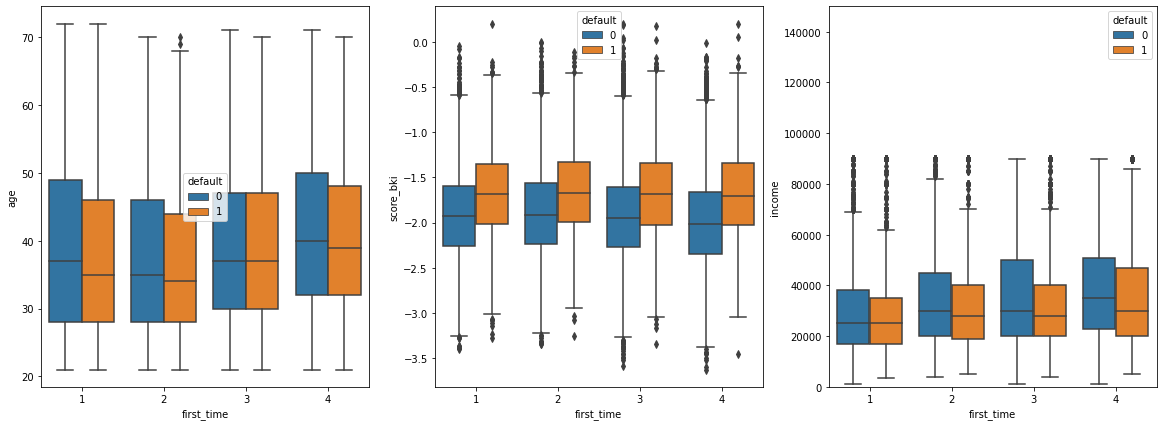

In [29]:
# Расмотрим категориальный признак 'first_time', как соотношение вернувших
# и не вернувших изменяется по категориям этого признака


default_ratio('first_time') 

region_rating  default
20             0          0.786408
               1          0.213592
30             0          0.810000
               1          0.190000
40             0          0.830298
               1          0.169702
50             0          0.863859
               1          0.136141
60             0          0.871166
               1          0.128834
70             0          0.907566
               1          0.092434
80             0          0.926846
               1          0.073154
Name: default, dtype: float64

<AxesSubplot:xlabel='region_rating', ylabel='age'>

<AxesSubplot:xlabel='region_rating', ylabel='score_bki'>

<AxesSubplot:xlabel='region_rating', ylabel='income'>

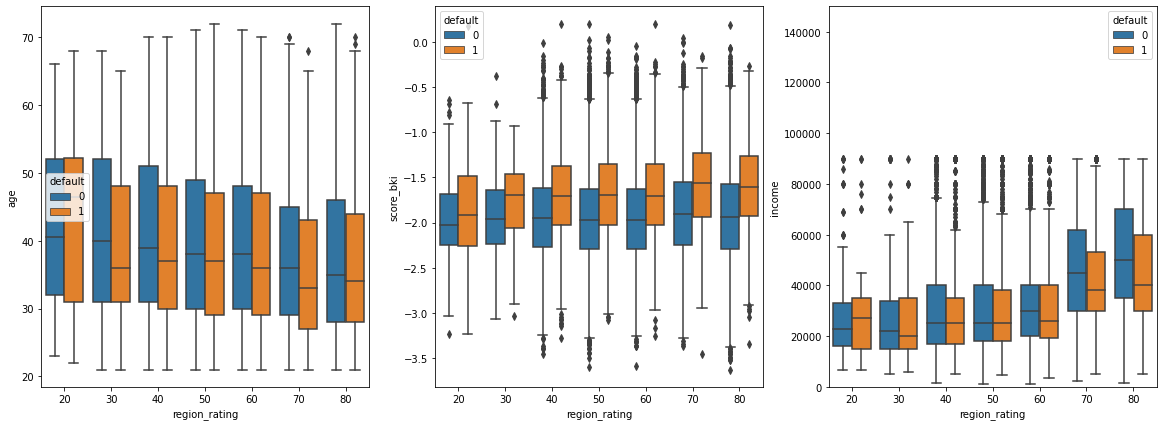

In [30]:
# Расмотрим категориальный признак 'region_rating', как соотношение вернувших
# и не вернувших изменяется по категориям этого признака


default_ratio('region_rating') 

home_address  default
1             0          0.907104
              1          0.092896
2             0          0.844854
              1          0.155146
3             0          0.883943
              1          0.116057
Name: default, dtype: float64

<AxesSubplot:xlabel='home_address', ylabel='age'>

<AxesSubplot:xlabel='home_address', ylabel='score_bki'>

<AxesSubplot:xlabel='home_address', ylabel='income'>

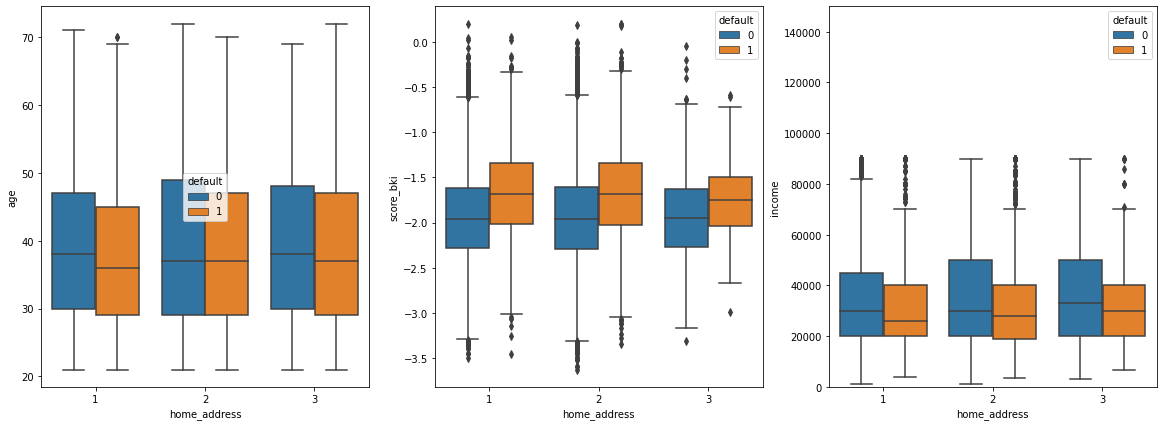

In [31]:
# Расмотрим категориальный признак 'home_address', как соотношение вернувших
# и не вернувших изменяется по категориям этого признака


default_ratio('home_address') 


bki_request_cnt  default
0                0          0.905010
                 1          0.094990
1                0          0.881210
                 1          0.118790
2                0          0.867627
                 1          0.132373
3                0          0.854359
                 1          0.145641
4                0          0.848765
                 1          0.151235
5                0          0.830477
                 1          0.169523
6                0          0.836268
                 1          0.163732
7                0          0.842723
                 1          0.157277
8                0          0.781197
                 1          0.218803
Name: default, dtype: float64

<AxesSubplot:xlabel='bki_request_cnt', ylabel='age'>

<AxesSubplot:xlabel='bki_request_cnt', ylabel='score_bki'>

<AxesSubplot:xlabel='bki_request_cnt', ylabel='income'>

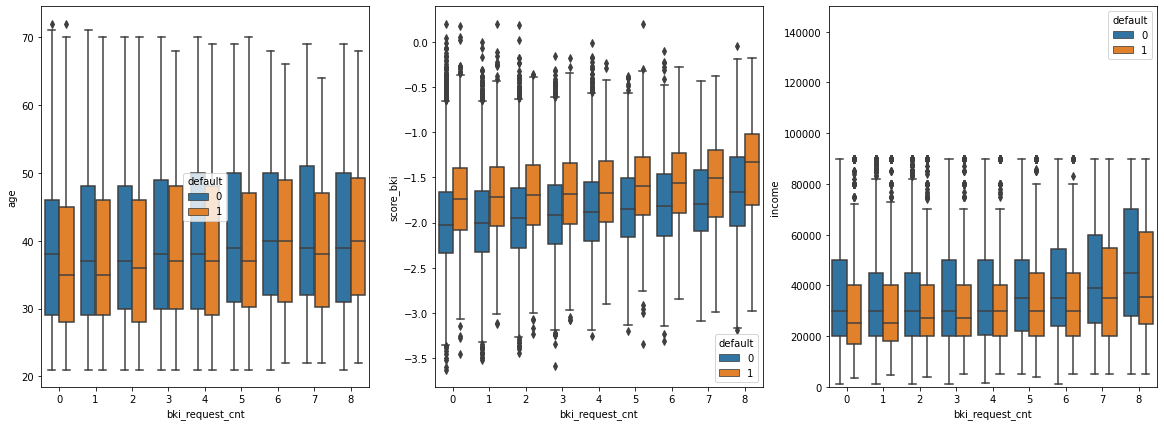

In [32]:
# Расмотрим категориальный признак 'bki_request_cnt', как соотношение вернувших
# и не вернувших изменяется по категориям этого признака


default_ratio('bki_request_cnt') 


education  default
ACD        0          0.958763
           1          0.041237
GRD        0          0.909908
           1          0.090092
PGR        0          0.935561
           1          0.064439
SCH        0          0.849695
           1          0.150305
UGR        0          0.868480
           1          0.131520
Name: default, dtype: float64

<AxesSubplot:xlabel='education', ylabel='age'>

<AxesSubplot:xlabel='education', ylabel='score_bki'>

<AxesSubplot:xlabel='education', ylabel='income'>

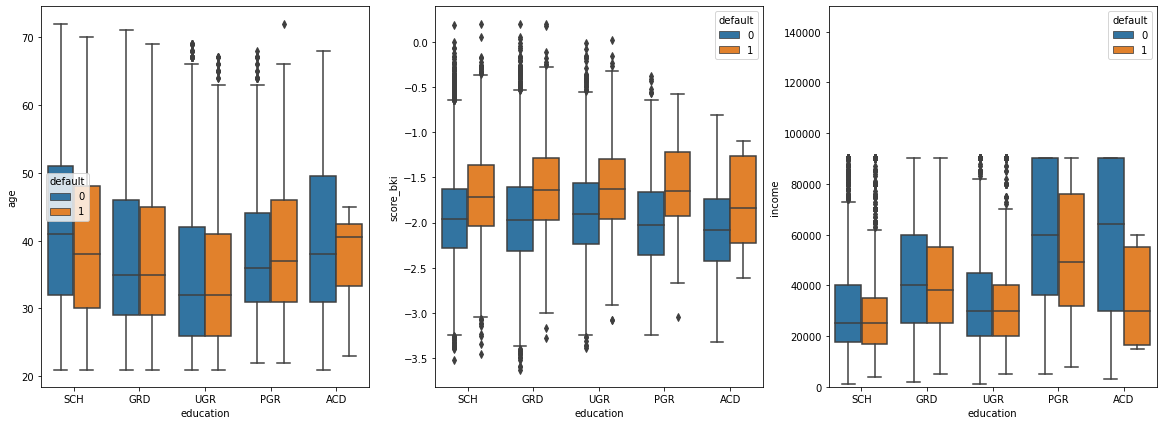

In [33]:



default_ratio('education') 

In [34]:
# Из бaксплот выше видно что зарплаты увеличивается с образованием
# но если образование одинаковое, то зарплата практическе одинаковая
# у тех кто вернул и не вернул кредит

sex_M  default
0      0          0.878759
       1          0.121241
1      0          0.865589
       1          0.134411
Name: default, dtype: float64

<AxesSubplot:xlabel='sex_M', ylabel='age'>

<AxesSubplot:xlabel='sex_M', ylabel='score_bki'>

<AxesSubplot:xlabel='sex_M', ylabel='income'>

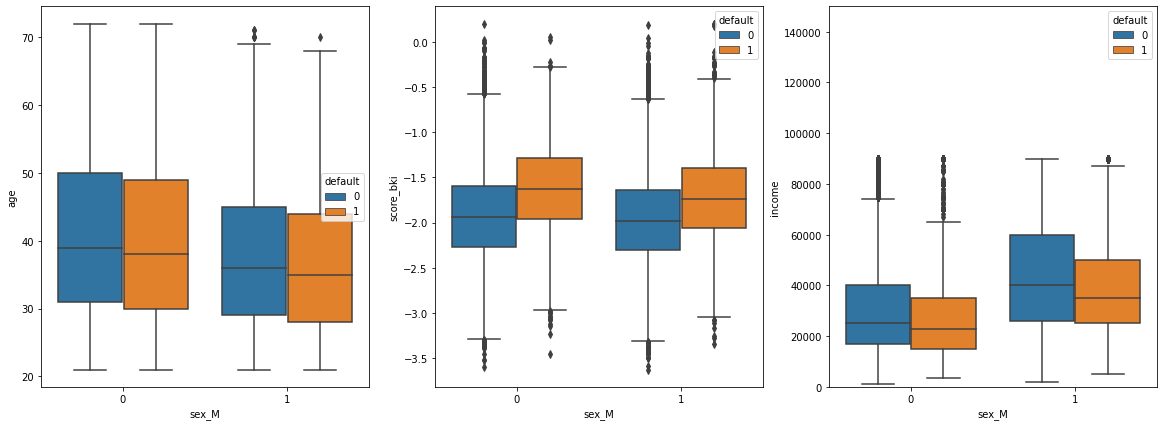

In [35]:
# посмотрим распределение среди мужчин и женщин
default_ratio('sex_M')

In [36]:
# В собранных данных у мужчин вернувших и невернувших 'income' заметно выше.
# Но на 'score_bki' это не отразилось, посмотрим как это нам поможет использая 'income' и
# деля по полу поможет создовать новые признаки.

In [37]:
df[df.sample_kaggle == 1].groupby(
    ['sna', 'decline_app_cnt', 'first_time']).default.value_counts(normalize=True).head(50)

sna  decline_app_cnt  first_time  default
1    0                1           0          0.866279
                                  1          0.133721
                      2           0          0.884818
                                  1          0.115182
                      3           0          0.911951
                                  1          0.088049
                      4           0          0.937241
                                  1          0.062759
     1                1           0          0.751553
                                  1          0.248447
                      2           0          0.804843
                                  1          0.195157
                      3           0          0.851743
                                  1          0.148257
                      4           0          0.874339
                                  1          0.125661
     2                1           0          0.662162
                                  1     

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Вернувшии клиенты  income


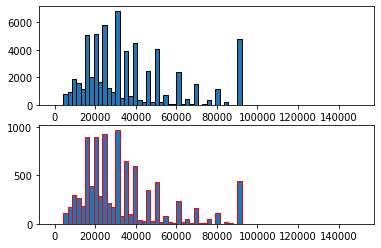

Невернувшии клиенты  income
----------------------
Вернувшии


count    64427.000000
mean     36898.658528
std      22537.362476
min       1000.000000
25%      20000.000000
50%      30000.000000
75%      50000.000000
max      90000.000000
Name: income, dtype: float64

Невернувшии


count     9372.000000
mean     32842.616090
std      20179.876633
min       3700.000000
25%      20000.000000
50%      28000.000000
75%      40000.000000
max      90000.000000
Name: income, dtype: float64

In [38]:
distrib_function('income', 70, (0, 150000))

In [39]:
# Этот DataFrame содержит много категориальных признаков и соотношения вернувших и невернувших изменяется
# в разных категориях. Можно использовать это для создания дополнительных признаков, которые будут дополнительно
# подчеркивать эти соотношения и возможно признаки как 'income' и 'age' станут большую роль играть в созданых категориях

In [40]:
#sns.violinplot(x='education', y='income', data = df[df.sample_kaggle == 1][df.region_rating > 40][df.home_address == 3], hue = 'default')

In [41]:
df['t_car'] = df['car_Y'] + df['car_type_Y'] + df['foreign_passport_Y'] + df['ed']

KeyError: 'ed'

# Дополнительные Признаки

In [42]:
# Самый важный признак 'score_bki' решил расмотреть по категориям
# и составить таблицу статистики по категориям, обнаружилось много
# категорий с выбросами поэтому решил для каждой категории собрать
# нижний и верхний барьер 'score_bki'

df['score_bki_positive'] = - 1 * df['score_bki']
bki_desc = df.groupby(['decline_app_cnt', 'bki_request_cnt',
                       'sna', 'first_time', 'sex_M']).score_bki_positive.describe()


def bounds(row):
    dif = row['75%'] - row['25%']

    return row['75%'] + 1.5 * dif


bki_desc['up_bound'] = bki_desc.apply(bounds, axis=1)


def bounds_low(row):
    dif = row['75%'] - row['25%']

    return row['25%'] - 1.5 * dif


bki_desc['low_bound'] = bki_desc.apply(bounds_low, axis=1)

bki_desc.head(50)


count      mean  \
decline_app_cnt bki_request_cnt sna first_time sex_M                     
0               0               1   1          0       433.0  1.959727   
                                               1       348.0  1.947973   
                                    2          0      1110.0  1.981018   
                                               1       901.0  1.998955   
                                    3          0      4151.0  2.020786   
                                               1      3578.0  2.032902   
                                    4          0      3250.0  2.073919   
                                               1      2958.0  2.094040   
                                2   1          0       315.0  1.965352   
                                               1       251.0  1.877746   
                                    2          0       486.0  1.926314   
                                               1       449.0  1.920508   
                                    3          0       835.0  1.942409   
                                               1       727.0  1.989979   
                                    4          0       175.0  1.980883   
                                               1       169.0  2.005855   
                                3   1          0       211.0  1.900147   
                                               1       150.0  1.923653   
                                    2          0       235.0  1.843922   
                                               1       169.0  1.932648   
                                    3          0       260.0  1.929663   
                                               1       209.0  1.944337   
                                    4          0        36.0  1.967124   
                                               1        43.0  2.071246   
                                4   1          0      1312.0  1.958676   
                                               1       979.0  1.979176   
                                    2          0       208.0  1.850969   
                                               1       216.0  1.867957   
                                    3          0       407.0  1.903990   
                                               1       328.0  1.916013   
                                    4          0        96.0  2.001170   
                                               1        95.0  1.980033   
                1               1   1          0       426.0  1.950951   
                                               1       311.0  1.968579   
                                    2          0       985.0  1.920601   
                                               1       811.0  1.972137   
                                    3          0      3887.0  1.993339   
                                               1      3216.0  2.013359   
                                    4          0      3098.0  2.042100   
                                               1      2560.0  2.074296   
                                2   1          0       304.0  1.870037   
                                               1       254.0  1.914656   
                                    2          0       483.0  1.916282   
                                               1       404.0  1.911661   
                                    3          0       817.0  1.929824   
                                               1       679.0  1.941860   
                                    4          0       165.0  2.012407   
                                               1       165.0  2.066232   
                                3   1          0       180.0  1.890673   
                                               1       154.0  1.896293   

                                                           std       min  \
decline_app_cnt bki_request_cnt sna first_time sex_M                       
0               0               1   1          0      

In [43]:
# Поэксперементировав с таблицей выше, решил создать признак 'new_bki_version_work'
# Он стал даже важнее признака 'score_bki' в модели

def new_bki_version(row):
    time = row['first_time']
    sna = row['sna']
    #edc = row['ed+pass']
    dec = row['decline_app_cnt']
    req = row['bki_request_cnt']
    sex = row['sex_M']
    # work = row['good_work']
    #car = row['car_Y']
    #r_rating = row['region_rating']
    bki = row['score_bki_positive']
    maks = bki_desc['up_bound'][(dec, req, sna, time, sex)]
    miin = bki_desc['low_bound'][(dec, req, sna, time, sex)]
    mean = bki_desc['mean'][(dec, req, sna, time, sex)]
    return (miin - 0.525) + (maks - 3.29) + ((mean - 1.904535) + (bki - mean)) * 0.5


df['new_bki_version_work'] = df[['decline_app_cnt', 'bki_request_cnt', 'sna',
                                 'first_time', 'sex_M', 'score_bki_positive']].apply(new_bki_version, axis=1)

In [44]:
# Корреляция с 'default' самых важных признаков
df[df.sample_kaggle == 1][['sna', 'first_time',  'score_bki',  'new_bki_version_work',
                           'income', 'bki_request_cnt', 'decline_app_cnt', 'default']].corr()['default']

sna                     0.125832
first_time             -0.105579
score_bki               0.175369
new_bki_version_work   -0.203636
income                 -0.060582
bki_request_cnt         0.076790
decline_app_cnt         0.121318
default                 1.000000
Name: default, dtype: float64

In [45]:
# Еще одна категориальная комбинация разделение данных на категории где разные соотношение
# вернувших и не вернувших кредит

prob_table = df[df.sample_kaggle == 1].groupby(
    ['decline_app_cnt', 'bki_request_cnt', 'sna', 'sex_M']).default.value_counts(normalize=True)

flag = 0


def prob_def(row):

    dec = row['decline_app_cnt']
    req = row['bki_request_cnt']
    sna = row['sna']
    sex = row['sex_M']

    if req == 7:
        req = 6
    try:
        prob = prob_table[dec][req][sna][sex][0]

    except KeyError:
        
        if req == 1:
            req = 2

        else:

            dec = 1
        prob = prob_table[dec][req][sna][sex][0]

    return prob


df['probability'] = df[['decline_app_cnt', 'bki_request_cnt',
                        'sna', 'sex_M']].apply(prob_def, axis=1)

In [46]:
# дополнительный признак 
df['prob_income'] = -1 * df['probability'] * df['score_bki'] / ((df['decline_app_cnt'] + 1))

In [47]:
# Теперь построим признак распределение заработка по категориям
# 'decline_app_cnt', 'bki_request_cnt', 'sna', 'sex_M'

income = df[df.sample_kaggle == 1].groupby(
    ['decline_app_cnt', 'bki_request_cnt', 'sna', 'sex_M']).income.mean()

flag = 0


def income_ratio(row):

    dec = row['decline_app_cnt']
    req = row['bki_request_cnt']
    sna = row['sna']
    sex = row['sex_M']

    if req == 7:
        req = 6

    try:
        prob = income[dec][req][sna][sex]

    except KeyError:

        if ed == 'ACD':

            ed = 'PGR'

        else:

            dec = 1
        prob = income[dec][req][sna][sex]

    return prob


df['income_mean'] = df[['decline_app_cnt', 'bki_request_cnt',
                        'sna', 'sex_M']].apply(income_ratio, axis=1)

In [48]:
# Этот признак построин будет на распределение среднего 'score_bki' по
# признакам 'age', 'sex_M', 'education', 'good_work'

nature_table = df.groupby(
    ['age', 'sex_M', 'education', 'good_work']).score_bki.mean()


def natural_table_mean(row):

    age = row['age']
    sex = row['sex_M']
    ed = row['education']
    w = row['good_work']

    if age > 68:
        age = 68

    if ed == 'ACD' or ed == 'PGR':
        ed == 'GRD'

    if ed == 'UGR' and age == 68 and sex == 1:
        ed = 'SCH'
    try:
        result = nature_table[age][sex][ed][w]

    except KeyError:

        if w == 1 and age == 68:
            age = 66

        result = nature_table[age][sex][ed][w]

    return result


df['natural_bki'] = df[['age', 'sex_M', 'education',
                        'good_work']].apply(natural_table_mean, axis=1)

In [49]:
# Несколько дополнительных признаков комбинаций

df['bki_difference'] = ((df['score_bki'] - df['natural_bki']) ** 2)

df['address_ratio'] = -1 * df['score_bki'] * \
    df['region_rating'] / (4 * df['home_address'])

df['bki_to_nature'] = 2 * df['natural_bki'] * \
    df['probability'] / df['address_ratio']

In [50]:
# Еще один признак на основе распределение 'score_bki', только учитывая другии
# эти категориальные признаки 'decline_app_cnt', 'sex_M', 'good_work', 'first_time', 'education'


bki_table = df.groupby(['decline_app_cnt', 'sex_M',
                        'good_work', 'first_time', 'education']).score_bki.mean()


def average_bki(row):
    dec = row['decline_app_cnt']
    sex = row['sex_M']
    work = row['good_work']
    time = row['first_time']
    ed = row['education']

    bki_mean = bki_table[dec][sex][work][time][ed]

    return bki_mean


df['bki_average'] = df[['decline_app_cnt', 'sex_M', 'good_work',
                        'first_time', 'education']].apply(average_bki, axis=1)

In [51]:
# Еще один признак построен будет на распределении соотношений между вернувшими
# и невернувшими использая следующии признаки 'first_time', 'sna', 'region_rating'

prob2_table = df[df.sample_kaggle == 1].groupby(
    ['first_time', 'sna', 'region_rating']).default.value_counts(normalize=True)


def probability_2(row):
    time = row['first_time']
    sna = row['sna']
    reg_rating = row['region_rating']

    if reg_rating == 20 or reg_rating == 30:
        reg_rating = 40

    result = prob2_table[time][sna][reg_rating][0]

    return result


df['probability_2'] = df[['first_time', 'sna',
                          'region_rating']].apply(probability_2, axis=1)

In [52]:
# Еще один признак на основе распределение 'score_bki', только учитывая другии
# эти категориальные признаки 'first_time', 'sna', 'region_rating'

bki_mean_3 = df.groupby(
    ['first_time', 'sna', 'region_rating']).score_bki.mean()


def bki_mean3(row):
    time = row['first_time']
    sna = row['sna']
    reg_rating = row['region_rating']

    if reg_rating == 20 or reg_rating == 30:
        reg_rating = 40

    result = bki_mean_3[time][sna][reg_rating]

    return result


df['bki_score_3'] = df[['first_time', 'sna',
                        'region_rating']].apply(bki_mean3, axis=1)

In [53]:
# Дополнительный признак комбинация

df['bki_ratio_3'] = df['prob_income'] * \
    ((df['score_bki'] - df['bki_score_3']) ** 2)



In [54]:
# признак распределение заработка по категориям
# 'first_time', 'sna', 'region_rating'

income_mean_3 = df.groupby(
    ['first_time', 'sna', 'region_rating']).income.mean()


def income_mean3(row):
    time = row['first_time']
    sna = row['sna']
    reg_rating = row['region_rating']

    if reg_rating == 20 or reg_rating == 30:
        reg_rating = 40

    result = income_mean_3[time][sna][reg_rating]

    return result


df['income_mean_3'] = df[['first_time', 'sna',
                          'region_rating']].apply(income_mean3, axis=1)

In [55]:
# Признаки комбинации и соотношения

df['9th_ratio'] = df['income_mean_3'] / df['income']

df['prob_bki'] = df['probability'] * df['bki_average']

df['bki_ratio'] = (df['bki_average']) / (df['score_bki'] * df['income'])

df['sc_formula'] = (df['good_work'] + df['first_time'] +
                    (df['region_rating'] / 10) - df['work_address'] - df['sna']) * df['income']

In [56]:
df['new_ratio'] = df['score_bki'] / \
    (df['decline_app_cnt'] + df['bki_request_cnt'] + 1)

df['region_ratio'] = (df['region_rating'] + 20 *
                      df['good_work']) / (5 * df['work_address'])

df['address_ratio'] = -1 * df['score_bki'] * \
    df['region_rating'] / (4 * df['home_address'])

df['second_ratio'] = df['address_ratio'] * df['prob_income']

df['third_ratio'] = df['prob_bki'] * df['score_bki'] / df['address_ratio']

df['fourth_ratio'] = (df['second_ratio'] ** df['third_ratio']
                      ) * df['score_bki'] / (4 * df['sna'])

df['fifth_ratio'] = df['first_time'] * df['sna'] * df['income']

In [57]:
df['sixt_ratio'] = (df['third_ratio'] * df['probability_2']
                    ) / (df['second_ratio'] ** 0.5)

df['7th_ratio'] = df['fourth_ratio'] * \
    (df['second_ratio']) ** (round(df['score_bki']))

df['8th_ratio'] = abs(df['fourth_ratio'] * df['new_ratio']) / (df['region_rating'] +
                                                               abs((df['sc_formula'] / 100) * df['second_ratio'] * df['score_bki']) ** 0.5) ** 0.5

df['10th_ratio'] = df['second_ratio'] / \
    (df['income_mean_3'] * df['probability_2'] * df['first_time'])

df['11th_ratio'] = ((df['probability_2'] * (df['sna'] +
                                            df['first_time']) / (df['home_address'])) + df['home_address'])

df['12th_ratio'] = df['second_ratio'] / \
    abs(df['11th_ratio'] + df['score_bki']) ** 0.5

# Построение Модели

In [58]:
df_preproc = df.copy()



In [59]:
df_preproc.drop(['client_id', 'app_date', 'education', 'age', 'decline_app_cnt', 'good_work',
                 'bki_request_cnt', 'home_address', 'work_address', 'income', 'month',
                 'day_of_month', 'sc_formula', 'new_ratio',  'bki_ratio', 'bki_average',
                 'probability', 'prob_income',  'prob_bki', 'third_ratio', 'fourth_ratio',
                 'natural_bki', 'bki_to_nature', 'bki_difference', 'fifth_ratio', 'probability_2',
                 'sixt_ratio', 'bki_ratio_3', '7th_ratio', '8th_ratio', '9th_ratio', '10th_ratio',
                 '11th_ratio', '12th_ratio', 'new_bki_version_work'], axis=1, inplace=True)


num_cols = ['age', 'decline_app_cnt', 'good_work', 'bki_request_cnt', 'home_address', 'work_address', 'income',
            'month', 'day_of_month', 'sc_formula', 'new_ratio',  'bki_ratio', 'bki_average', 'probability',
            'prob_income', 'prob_bki', 'third_ratio', 'fourth_ratio', 'natural_bki', 'bki_to_nature', 'bki_difference',
            'fifth_ratio', 'probability_2', 'sixt_ratio', 'bki_ratio_3', '7th_ratio', '8th_ratio', '9th_ratio',
            '10th_ratio', '11th_ratio', '12th_ratio', 'new_bki_version_work']


X_num = StandardScaler().fit_transform(df[num_cols].values)
X_num = pd.DataFrame(X_num, columns=num_cols)





In [60]:

df_preproc = pd.concat([df_preproc, X_num], axis=1)
df_preproc['offset'] = 1

df_preproc = df_preproc.drop(['income_mean', 'probability', 'bki_score_3', 'income_mean_3', 'probability_2', 'score_bki_positive',
                              'foreign_passport_Y',  'prob_income', 'second_ratio', 'address_ratio', 'fourth_ratio', 'sixt_ratio'], axis=1)


train_data = df_preproc.query('sample_kaggle == 1').drop([
    'sample_kaggle'], axis=1)
test_data = df_preproc.query('sample_kaggle == 0').drop([
    'sample_kaggle'], axis=1)

Y = train_data.default.values
X = train_data.drop(['default'], axis=1)

X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73799 entries, 36349 to 110147
Data columns (total 41 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   score_bki             73799 non-null  float64
 1   region_rating         73799 non-null  int64  
 2   sna                   73799 non-null  int64  
 3   first_time            73799 non-null  int64  
 4   ed_ACD                73799 non-null  uint8  
 5   ed_GRD                73799 non-null  uint8  
 6   ed_PGR                73799 non-null  uint8  
 7   ed_SCH                73799 non-null  uint8  
 8   ed_UGR                73799 non-null  uint8  
 9   sex_M                 73799 non-null  uint8  
 10  car_Y                 73799 non-null  uint8  
 11  car_type_Y            73799 non-null  uint8  
 12  region_ratio          73799 non-null  float64
 13  age                   73799 non-null  float64
 14  decline_app_cnt       73799 non-null  float64
 15  good_work     

<AxesSubplot:>

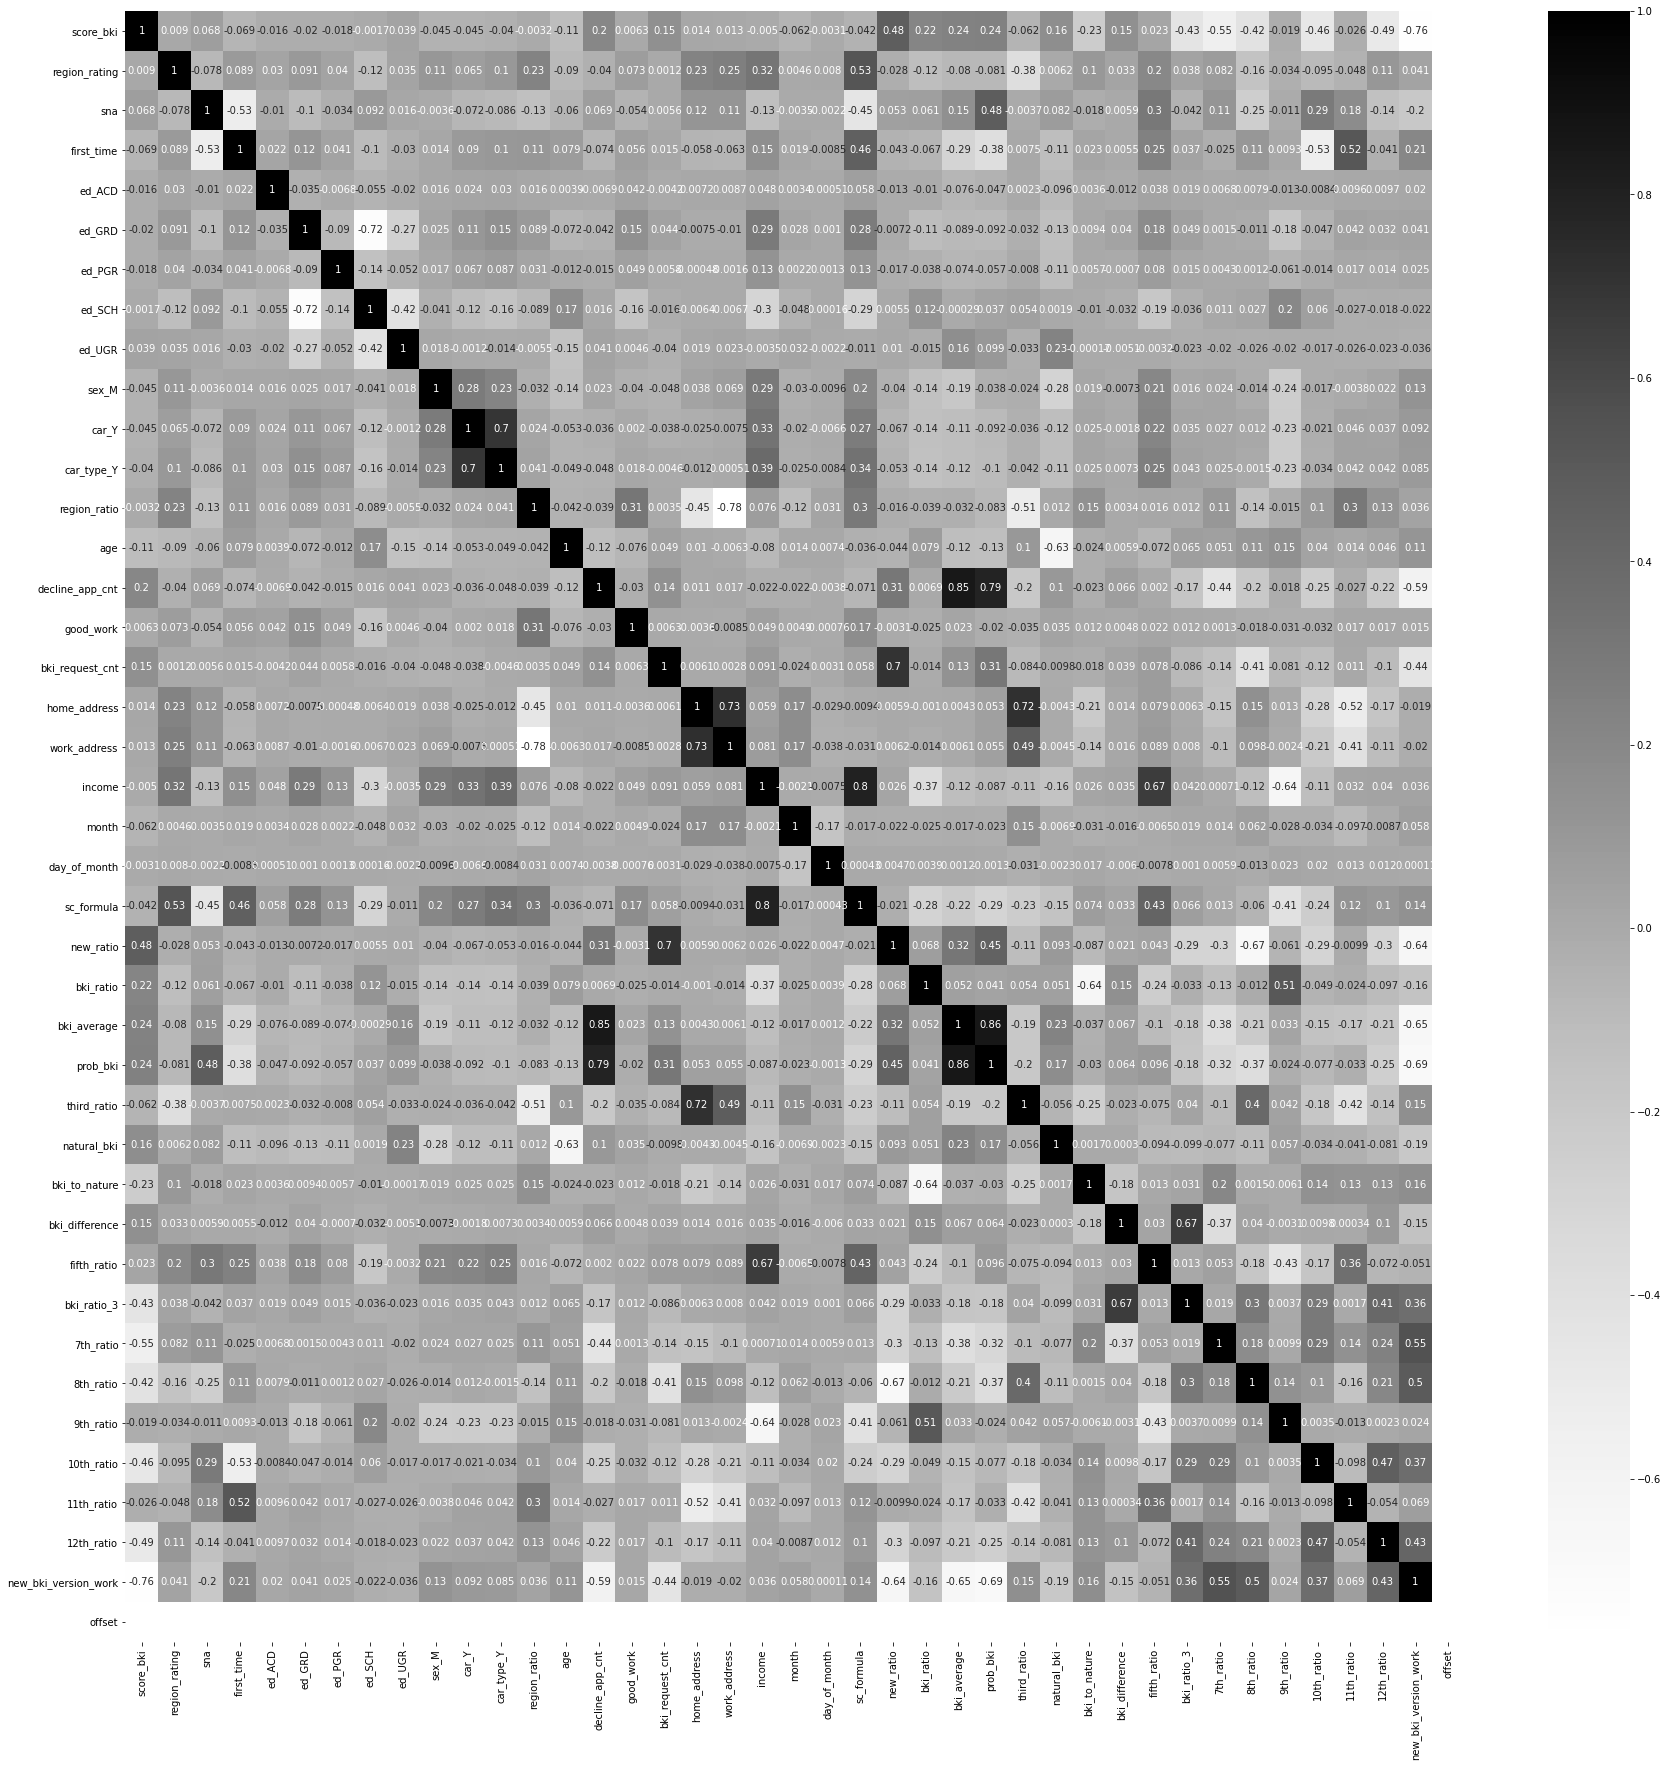

In [61]:
df_corr = X.corr()

plt.figure(figsize=(30,30))
sns.heatmap(df_corr, annot=True, cmap='Greys')

In [62]:
#from sklearn.decomposition import PCA
#pca = PCA(n_components=30)

#prinComp = pca.fit_transform(X)

# Первая Модель Logistic regression

In [63]:
# создаем модель
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

model = LogisticRegression(penalty='l2')
model.fit(X_train, y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression()

0.7490502078604686

confusion_matrix


array([[12874,    59],
       [ 1766,    61]])

Precision Score


0.5083333333333333

f_value


0.06266050333846944

precision negative


0.8793715846994535

precision positive


0.5083333333333333

recall negative


0.9954380267532669

recall postive


0.033388067870826495

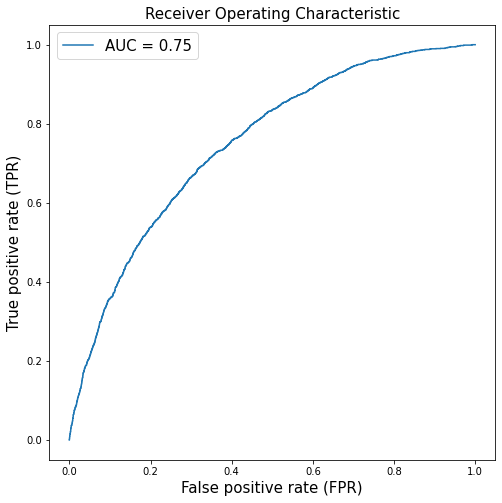

In [64]:
result_calculations(X_test, y_test, model)
    
    

# Voting Algorithm

**Ниже модель комбинация трех алгоритмов, которые выдали лучший результат
чем просто Logistic Regression. VotingClassifier это комбинатор алгоритмов
который смотрит как голосуют в процентном отношение каждый из алгоритмов
классификации и потом считает к какому классу отнести по общему весу голосов.
В данном примере я использовал Logistic Regression, Light Gradient Boosting Machine и
CatBoostClassifier. K-Nearest Neighbors убрал из модели, потому что он ее ухудшал.**

In [65]:

model = LogisticRegression(penalty='l2')
lg_model = LGBMClassifier(learning_rate=0.05, n_estimators=80, num_leaves=100)
cb_ = CatBoostClassifier(
    objective='CrossEntropy',
    iterations=100,
    random_seed=42,
    learning_rate=0.2,
    colsample_bylevel=0.1,
    depth=4,
    custom_loss=['AUC'],
    early_stopping_rounds=30,
    boosting_type='Plain')

voting_model = VotingClassifier(estimators=[(
    'LN', model), ('lgbm', lg_model), ('cat', cb_)], voting='soft', weights=[11, 3, 4])

voting_model.fit(X_train, y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0:	learn: 0.5621090	total: 79.3ms	remaining: 7.85s
1:	learn: 0.4781935	total: 100ms	remaining: 4.92s
2:	learn: 0.4314123	total: 117ms	remaining: 3.78s
3:	learn: 0.4023104	total: 136ms	remaining: 3.25s
4:	learn: 0.3839214	total: 154ms	remaining: 2.92s
5:	learn: 0.3717809	total: 171ms	remaining: 2.68s
6:	learn: 0.3634810	total: 187ms	remaining: 2.48s
7:	learn: 0.3575981	total: 203ms	remaining: 2.33s
8:	learn: 0.3548685	total: 220ms	remaining: 2.23s
9:	learn: 0.3526579	total: 236ms	remaining: 2.12s
10:	learn: 0.3500470	total: 252ms	remaining: 2.04s
11:	learn: 0.3486648	total: 267ms	remaining: 1.96s
12:	learn: 0.3476248	total: 285ms	remaining: 1.91s
13:	learn: 0.3470509	total: 303ms	remaining: 1.86s
14:	learn: 0.3462811	total: 329ms	remaining: 1.87s
15:	learn: 0.3457821	total: 353ms	remaining: 1.85s
16:	learn: 0.3452780	total: 392ms	remaining: 1.91s
17:	learn: 0.3448117	total: 422ms	remaining: 1.92s
18:	learn: 0.3443078	total: 440ms	remaining: 1.87s
19:	learn: 0.3438929	total: 465ms	remain

VotingClassifier(estimators=[('LN', LogisticRegression()),
                             ('lgbm',
                              LGBMClassifier(learning_rate=0.05,
                                             n_estimators=80, num_leaves=100)),
                             ('cat',
                              <catboost.core.CatBoostClassifier object at 0x7fd47c11c3d0>)],
                 voting='soft', weights=[11, 3, 4])

0.7505273166732624

confusion_matrix


array([[12887,    46],
       [ 1775,    52]])

Precision Score


0.5306122448979592

f_value


0.054025974025974026

precision negative


0.8789387532396672

precision positive


0.5306122448979592

recall negative


0.9964432072991571

recall postive


0.028461959496442254

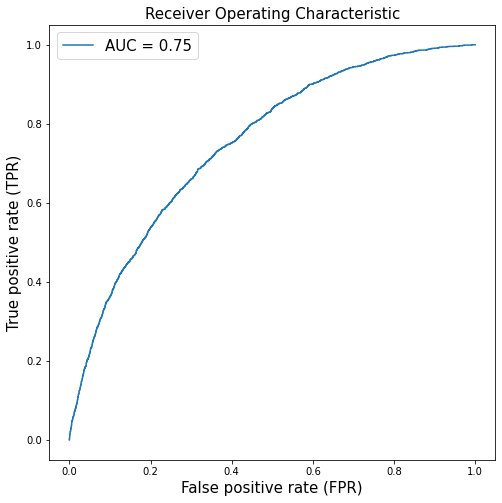

In [66]:
result_calculations(X_test, y_test, voting_model)

/opt/conda/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:115: UserWarning: Features [40] are constant.
  UserWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


<AxesSubplot:>

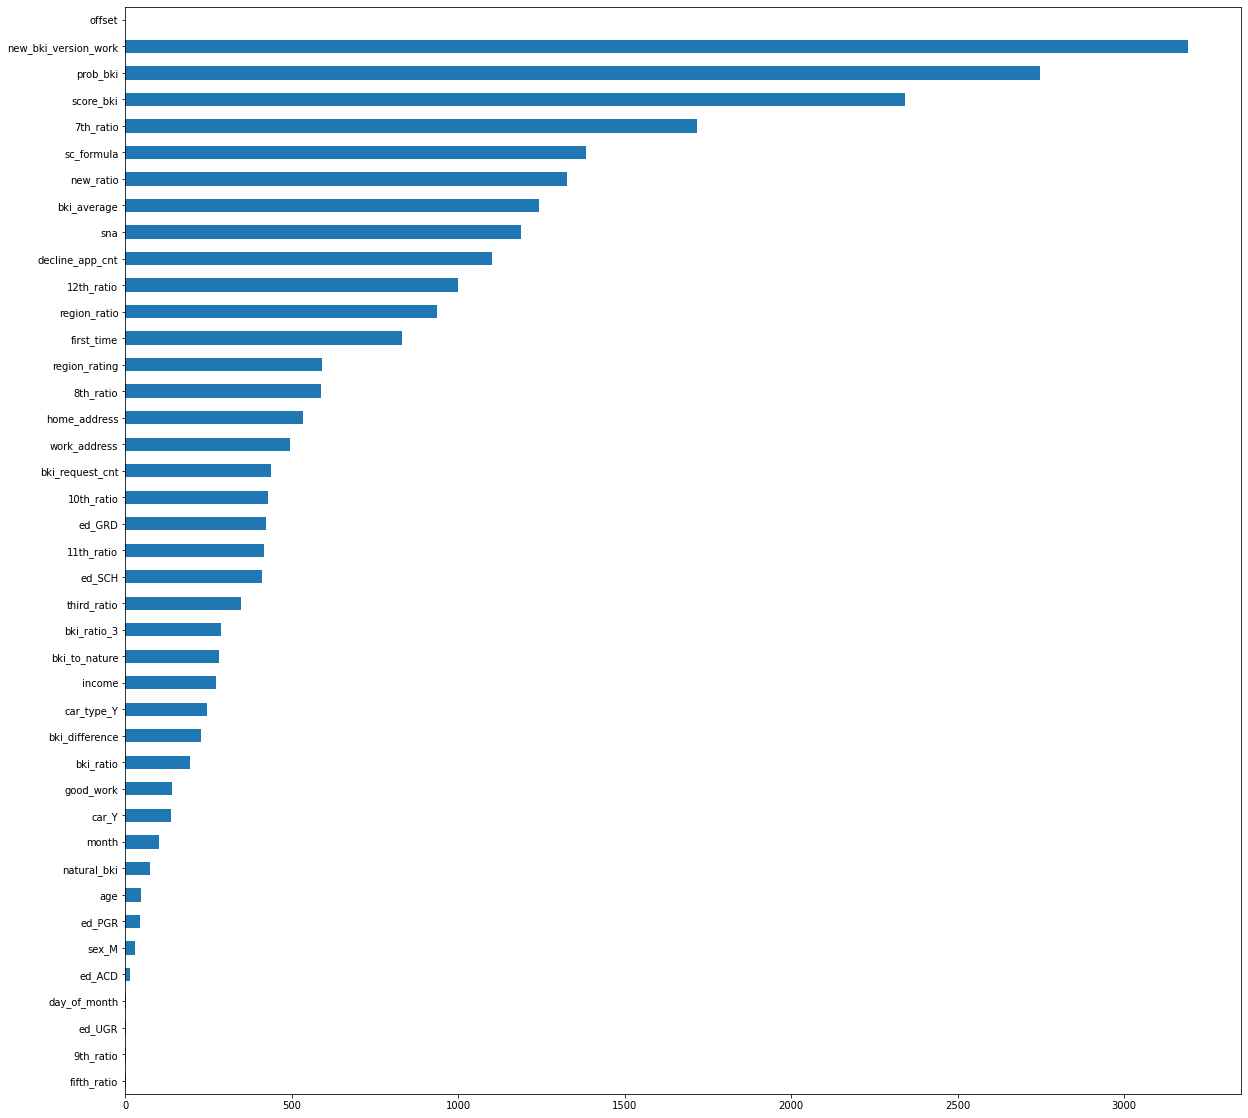

In [67]:
# Таблица показывающая на сколько важен каждый признак
# для алгоритма

plt.figure(figsize=(20,20))
imp_num = pd.Series(f_classif(X, Y)[0], index = list(X.columns))
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')


In [68]:
DATA_DIR = '/kaggle/input/sf-dst-scoring/'
test_data = test_data.drop(['default'], axis=1)
predict_submission = voting_model.predict_proba(test_data)


In [69]:
ids = df[df.sample_kaggle == 0].client_id
submission = pd.DataFrame({'client_id': ids,
                           'default': predict_submission[:,1]})
submission.to_csv('submission.csv', index=False)